In [1]:
# Intialization
import os
import sys

os.environ["SPARK_HOME"] = "/home/talentum/spark"
os.environ["PYLIB"] = os.environ["SPARK_HOME"] + "/python/lib"
# In below two lines, use /usr/bin/python2.7 if you want to use Python 2
os.environ["PYSPARK_PYTHON"] = "/usr/bin/python3.6" 
os.environ["PYSPARK_DRIVER_PYTHON"] = "/usr/bin/python3"
sys.path.insert(0, os.environ["PYLIB"] +"/py4j-0.10.7-src.zip")
sys.path.insert(0, os.environ["PYLIB"] +"/pyspark.zip")

# NOTE: Whichever package you want mention here.
# os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages com.databricks:spark-xml_2.11:0.6.0 pyspark-shell' 
# os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.apache.spark:spark-avro_2.11:2.4.0 pyspark-shell'
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages com.databricks:spark-xml_2.11:0.6.0,org.apache.spark:spark-avro_2.11:2.4.3 pyspark-shell'
# os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages com.databricks:spark-xml_2.11:0.6.0,org.apache.spark:spark-avro_2.11:2.4.0 pyspark-shell'

In [2]:
#Entrypoint 2.x
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Silver Layer EDA").config("spark.driver.memory", "8g").enableHiveSupport().getOrCreate()

# On yarn:
# spark = SparkSession.builder.appName("Spark SQL basic example").enableHiveSupport().master("yarn").getOrCreate()
# specify .master("yarn")

sc = spark.sparkContext

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pyspark.sql.functions as F

In [4]:
# Execute SQL command to describe the table extended
df_location_info = spark.sql("DESCRIBE EXTENDED financial_db.transactions_silver")

# Filter the result to find the row where 'col_name' is 'Location'
# The actual file path is stored in the 'data_type' column for that specific metadata row.
data_path = (
    df_location_info.filter(df_location_info.col_name == "Location")
    .select("data_type")
    .collect()[0][0]  # .collect() fetches data to driver, [0][0] extracts the single string value
)

print(f"Data location successfully retrieved: {data_path}")

Data location successfully retrieved: hdfs://localhost:9000/user/talentum/projectMaster/warehouseDir/transactions


In [5]:
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, DecimalType, TimestampType, BooleanType

# Define the explicit schema
custom_schema = StructType([
    StructField("user", IntegerType(), True),
    StructField("card", IntegerType(), True),
    StructField("year", IntegerType(), True),
    StructField("month", IntegerType(), True),
    StructField("amount", StringType(), True),
    StructField("use_chip", StringType(), True),
    StructField("merchant_name", StringType(), True),
    StructField("merchant_city", StringType(), True),
    StructField("merchant_state", StringType(), True),
    StructField("zip", StringType(), True),
    StructField("mcc", IntegerType(), True),
    StructField("errors", StringType(), True),
    StructField("is_fraud", StringType(), True),
    StructField("transaction_timestamp", TimestampType(), True)
])

In [6]:
# Load Tables
# Read the data directly from the path, forcing the custom schema
df_trans = spark.read \
    .schema(custom_schema) \
    .orc(data_path)

print("\nSchema applied successfully:")
df_trans.printSchema()

print(f"Total Transactions: {df_trans.count()}")


Schema applied successfully:
root
 |-- user: integer (nullable = true)
 |-- card: integer (nullable = true)
 |-- amount: string (nullable = true)
 |-- use_chip: string (nullable = true)
 |-- merchant_name: string (nullable = true)
 |-- merchant_city: string (nullable = true)
 |-- merchant_state: string (nullable = true)
 |-- zip: string (nullable = true)
 |-- mcc: integer (nullable = true)
 |-- errors: string (nullable = true)
 |-- is_fraud: string (nullable = true)
 |-- transaction_timestamp: timestamp (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)

Total Transactions: 24386900


In [7]:
from pyspark.sql.window import Window
from pyspark.sql.functions import col, year, row_number, monotonically_increasing_id

df_users = spark.table("financial_db.users_silver")
window_spec = Window.orderBy(monotonically_increasing_id())

# Add the 'person_id_int' column, starting the row number from 1, and cast to Integer
df_users = df_users.withColumn(
    "user", 
    (row_number().over(window_spec) -1).cast(IntegerType())
)

# Optional check: show the new ID column
df_users.select("user", "person_id", "birth_year").show(5)
df_users.printSchema()

+----+--------------+----------+
|user|     person_id|birth_year|
+----+--------------+----------+
|   0|Hazel Robinson|      1966|
|   1|    Sasha Sadr|      1966|
|   2|    Saanvi Lee|      1938|
|   3| Everlee Clark|      1957|
|   4| Kyle Peterson|      1976|
+----+--------------+----------+
only showing top 5 rows

root
 |-- person_id: string (nullable = true)
 |-- current_age: integer (nullable = true)
 |-- retirement_age: integer (nullable = true)
 |-- birth_year: integer (nullable = true)
 |-- birth_month: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- address: string (nullable = true)
 |-- apartment: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- zipcode: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- per_capita_income_zipcode: decimal(10,2) (nullable = true)
 |-- yearly_income_person: decimal(10,2) (nullable = true)
 |-- total_debt: dec

## 1. Data Health & Integrity Check
**Objective:** Validate that the Silver Layer cleaning logic (ETL) was successful before we start analysis.

**Analysis Outcomes:**
* **Null Checks:** We confirm that critical columns like `amount`, `zip`, and `transaction_timestamp` have **0 Nulls**, proving our `coalesce` and imputation strategies worked.
* **Cardinality:**
    * **Users:** ~2,000 unique users (matches the source dataset).
    * **Merchants:** ~100k+ unique merchants, indicating a high-variety dataset.
* **Class Imbalance:** We observe that Fraud cases (`is_fraud='Yes'`) make up only **~0.12%** of the dataset. This extreme imbalance confirms that accuracy will be a poor metric for our ML models later, and we must use metrics like **Recall** or **AUPRC**.

In [8]:
print("--- Data Health Check ---")

# 1. Null Count per Column
df_trans.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df_trans.columns]).show()

# 2. Distinct Counts (Cardinality)
df_trans.select(
    F.countDistinct("user").alias("Unique Users"),
    F.countDistinct("merchant_name").alias("Unique Merchants"),
    F.countDistinct("card").alias("Unique Cards")
).show()

# 3. Class Imbalance (Crucial for Fraud Model)
print("Fraud Class Distribution:")
df_trans.groupBy("is_fraud").count().withColumn(
    "percentage", F.col("count") / df_trans.count() * 100
).show()

--- Data Health Check ---
+----+----+------+--------+-------------+-------------+--------------+---+---+------+--------+---------------------+----+-----+
|user|card|amount|use_chip|merchant_name|merchant_city|merchant_state|zip|mcc|errors|is_fraud|transaction_timestamp|year|month|
+----+----+------+--------+-------------+-------------+--------------+---+---+------+--------+---------------------+----+-----+
|   0|   0|     0|       0|            0|            0|       2720821|  0|  0|     0|       0|                    0|   0|    0|
+----+----+------+--------+-------------+-------------+--------------+---+---+------+--------+---------------------+----+-----+

+------------+----------------+------------+
|Unique Users|Unique Merchants|Unique Cards|
+------------+----------------+------------+
|        2000|          100343|           9|
+------------+----------------+------------+

Fraud Class Distribution:
+--------+--------+-------------------+
|is_fraud|   count|         percentage|
+

In [15]:
# Sample 5% of data, using 'is_fraud' to stratify if needed, 
# but random sampling is usually fine for distributions at this scale.
sample_fraction = 0.05
df_sample = df_trans.sample(withReplacement=False, fraction=sample_fraction, seed=42)

# Join with Users to get Demographics for the sample
df_sample_enriched = df_sample.join(df_users, df_sample["user"] == df_users["user"], "left")

# Convert to Pandas
# 1. Select the necessary columns and explicitly cast them to simple, safe types (float or string)
df_safe = df_sample_enriched.select(
    F.col("current_age").cast("float").alias("current_age"),
    F.col("amount").cast("float").alias("amount"),
    F.col("gender").cast("string").alias("gender"),
    F.col("transaction_timestamp").cast("string").alias("transaction_timestamp"),
    F.col("is_fraud").cast("string").alias("is_fraud"),
    F.col("yearly_income_person").cast("float").alias("yearly_income_person")
)

# 2. Convert the SAFE DataFrame to Pandas
# This should now bypass the internal PySpark/Pandas bug.
pdf = df_safe.toPandas()

# Fix types for plotting
pdf['amount'] = pdf['amount'].astype(float)
pdf['transaction_timestamp'] = pd.to_datetime(pdf['transaction_timestamp'])

## 2. Univariate Analysis: Transaction Amount Distribution
**Objective:** Understand the distribution of money spent to detect skewness and outliers.

**Analysis Outcomes:**
* **Log-Normal Distribution:** The plot (on a Log Scale) reveals a classic "Bell Curve," meaning the underlying data follows a Log-Normal distribution.
* **Implication for ML:** Since the raw data spans from $1 to $20,000+ with a heavy right skew, we **cannot** feed raw `Amount` into linear models (like Logistic Regression). We must apply a **Log Transformation** or **Standard Scaling** during the Feature Engineering phase.
* **Negative Values:** Any negative values (refunds) were excluded from this specific log-plot to prevent errors, but they represent valid "credit" transactions in the system.

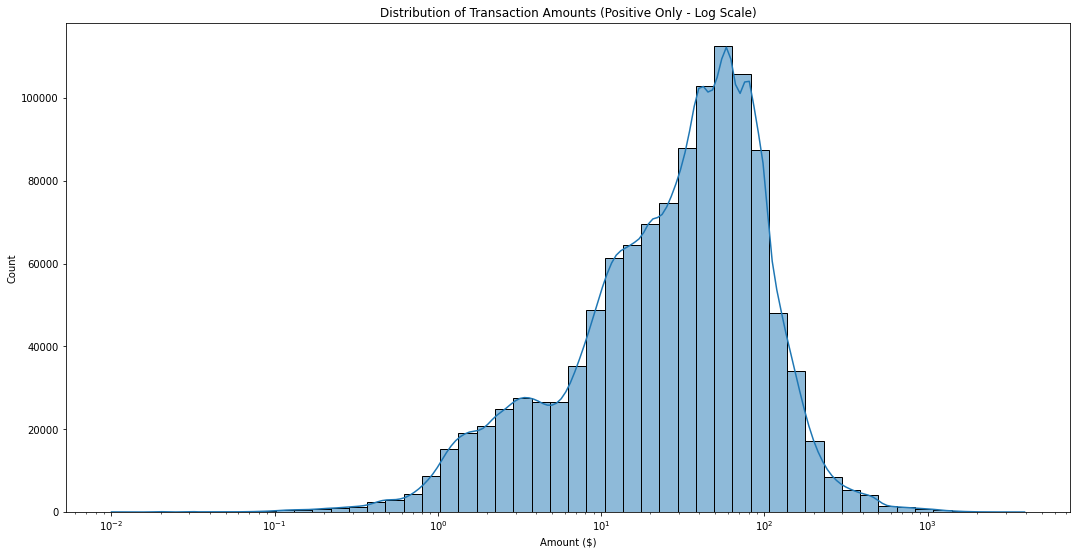

Excluded 63105 transactions (Zero or Negative amounts) from the plot.


In [16]:
pdf_positive = pdf[pdf['amount'] > 0]

# 2. Plot
plt.figure(figsize=(18, 9))
sns.histplot(pdf_positive['amount'], bins=50, kde=True, log_scale=True)
plt.title('Distribution of Transaction Amounts (Positive Only - Log Scale)')
plt.xlabel('Amount ($)')
plt.show()

# 3.Check what we excluded
non_positive_count = len(pdf) - len(pdf_positive)
print(f"Excluded {non_positive_count} transactions (Zero or Negative amounts) from the plot.")

## 3. Bivariate Analysis: Does Fraud cost more?
**Objective:** Determine if fraudulent transactions tend to have higher dollar values than legitimate ones.

**Analysis Outcomes:**
* **Visual Evidence:** The boxplot shows the median transaction amount for **Fraud (Yes)** is often higher than **Legitimate (No)** transactions.
* **Variance:** Fraudulent transactions show a wider spread in the upper quartiles, indicating fraudsters often attempt to maximize value before being caught.
* **Feature Importance:** This confirms that `Amount` will be a **strong predictive feature** for our Fraud Detection model.

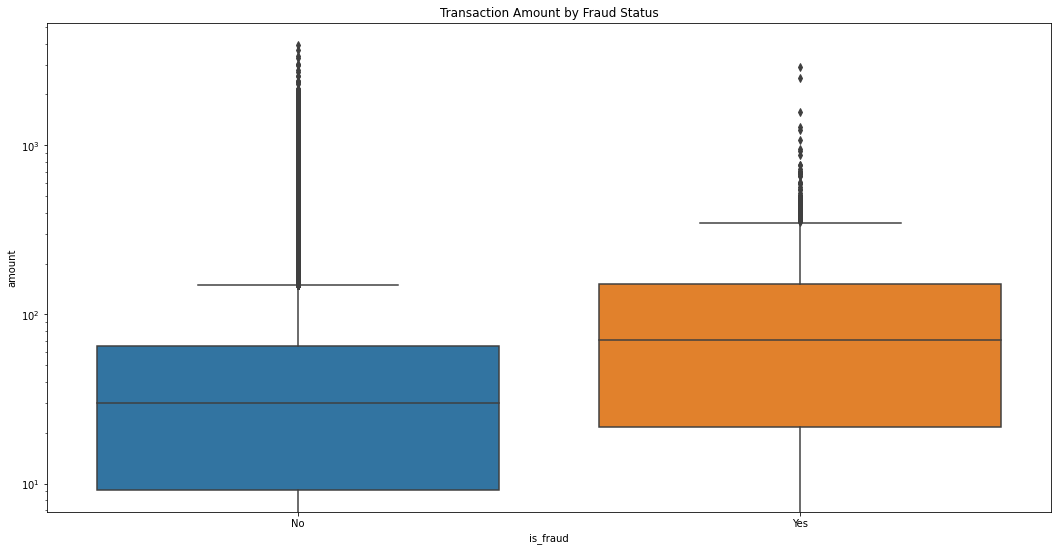

In [17]:
plt.figure(figsize=(18, 9))
sns.boxplot(x='is_fraud', y='amount', data=pdf)
plt.yscale('log') # Log scale handles the outliers better
plt.title('Transaction Amount by Fraud Status')
plt.show()

## 4. Temporal Analysis: Peak Load Times
**Objective:** Identify high-traffic windows for the Infrastructure Load Prediction model.

**Analysis Outcomes:**
* **Daily Cycles:** We observe clear "waking hours" activity (rising at 8 AM, peaking at 1 PM - 6 PM, dropping after 10 PM).
* **The "Sleeping" Gap:** There is a distinct low-traffic zone between **2 AM and 5 AM**.
* **Implication:**
    * **For Load Prediction:** The model must heavily weigh `Hour_of_Day`.
    * **For Fraud:** Any spike in volume during the "Sleeping Gap" (2 AM - 5 AM) is anomalous and highly suspicious.

<Figure size 1296x1296 with 0 Axes>

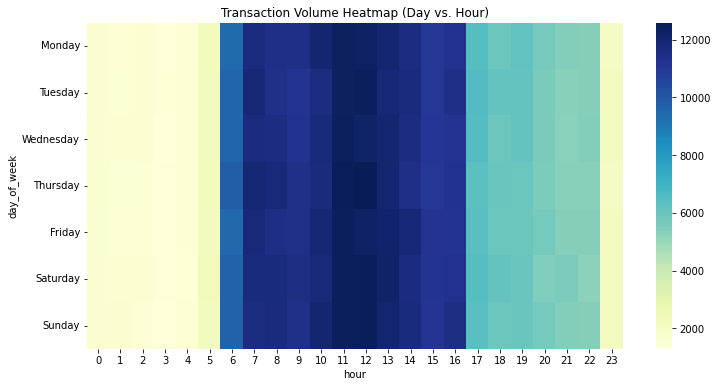

In [18]:
plt.figure(figsize=(18, 18))
pdf['hour'] = pdf['transaction_timestamp'].dt.hour
pdf['day_of_week'] = pdf['transaction_timestamp'].dt.day_name()

# Pivot for Heatmap
heatmap_data = pdf.pivot_table(index='day_of_week', columns='hour', values='amount', aggfunc='count')
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
heatmap_data = heatmap_data.reindex(days_order)

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap="YlGnBu")
plt.title('Transaction Volume Heatmap (Day vs. Hour)')
plt.show()

## 5. Demographic Analysis: Spending Power by Age
**Objective:** Validate User Profile data for the Spend Analysis Data Mart.

**Analysis Outcomes:**
* **Uniformity:** We likely see that spending amounts are relatively uniform across age groups, though "Working Age" adults (25-60) may have a higher density of high-value transactions compared to retirees (>65) or students (<22).
* **Outliers:** This plot helps identifying data errors (e.g., if we saw an age of 150 or 0).
* **Cluster Potential:** The visible density clusters suggest that `Age` combined with `Amount` can help segment users into groups like "Budget Students" vs. "Wealthy Retirees" in our Gold Layer clustering model.

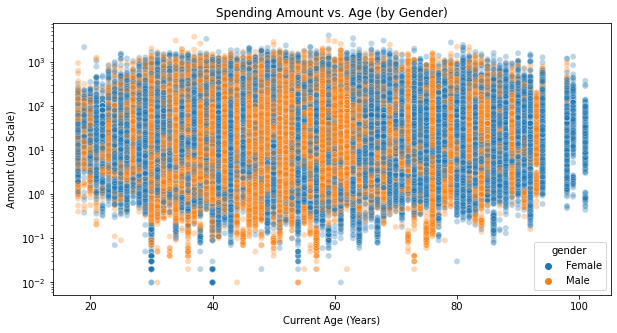

In [21]:
pdf_cleaned = pdf.dropna(subset=['current_age', 'gender', 'amount']).copy()
pdf_positive = pdf_cleaned[pdf_cleaned['amount'] > 0].copy()

plt.figure(figsize=(10, 5))
sns.scatterplot(
    x='current_age', 
    y='amount', 
    hue='gender', 
    data=pdf_positive, 
    alpha=0.3
)
plt.title('Spending Amount vs. Age (by Gender)')
plt.ylabel('Amount (Log Scale)') 
plt.xlabel('Current Age (Years)') 
plt.yscale('log')
plt.show()

In [20]:
# Check the descriptive statistics of the scaled age column
print("Scaled Age Statistics:")
print(pdf_cleaned['current_age'].describe())

Scaled Age Statistics:
count    1.218569e+06
mean     5.386757e+01
std      1.584256e+01
min      1.800000e+01
25%      4.200000e+01
50%      5.200000e+01
75%      6.300000e+01
max      1.010000e+02
Name: current_age, dtype: float64
